### Experimental Objective: Abrupt Drift Detection (Isolation Forest)

The primary objective of this experiment is to evaluate the sensitivity of the **Isolation Forest** algorithm to *abrupt* distributional shifts. Unlike gradual drift, this study simulates a systemic data shock using **Affine Remapping**, specifically designed to test the model's mechanistic response to sudden non-linear feature scaling.

**1.1 Experimental Design: Affine Remapping**
We simulate abrupt drift by re-scaling the feature space via a **Min-Max Affine Transformation** defined by two parameters:
* **Downward Shift ($\delta=0.4$):** Remaps minimum values to 40% of the original, creating a location shift. 
* **Range Expansion ($\sigma=1.5$):** Stretches the feature spread by 1.5x, effectively increasing the variance.

**1.2 Methodology & Workflow**
The experiment follows a strict "split-first" protocol to ensure rigorous validation:
1.  **Baseline Calibration:** A `70% temporal baseline` is used to train the Isolation Forest with `contamination=0.2`. This establishes a fixed sensitivity threshold (20% expected anomaly rate) for the "normal" profile.
2.  **Drift Injection:** The affine remapping is applied to the `entire 30% test set` to simulate an immediate population step-change.
3.  **Scenarios:**
    * **Univariate:** Remapping applied solely to `Glucose`.
    * **Multivariate:** Remapping applied simultaneously to `Glucose`, `BMI`, and `Age`.
4.  **Validation:** Performance is quantified via the **Detection Ratio** and validated using **SHAP** (for feature attribution) and **K-S Tests** (for statistical significance).


In [1]:

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.svm import OneClassSVM
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import shap 

# Load the UNIMPUTED (raw) data to prevent data leakage
data_path = Path("data/interim/pima_step1_clean.csv")
df = pd.read_csv(data_path)

# Create Missingness Flags from the raw NaN values
cols_with_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_missing:
    df[f"{col}_is_missing"] = df[col].isna().astype(int)

print("Loaded pima_step1_clean.csv and created missingness flags.")
print("Dataset loaded successfully. Shape:", df.shape)
df.head()

Loaded pima_step1_clean.csv and created missingness flags.
Dataset loaded successfully. Shape: (768, 14)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Glucose_is_missing,BloodPressure_is_missing,SkinThickness_is_missing,Insulin_is_missing,BMI_is_missing
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1,0,0,0,1,0
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0,0,0,0,1,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1,0,0,1,1,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,0,0,0,0,0


#### Data Partitioning for Simulation

**Purpose:** To create a baseline "training" set and a "test" set to simulate a post-deployment scenario.

**Partitioning Strategy:**
* **Method:** We use a **temporal (sequential)** 70/30 split, taking the first 70% of samples as the baseline set and the last 30% as the test set. This is done *before* any imputation or scaling to prevent data leakage.
* **Baseline Set (`X_base_raw`):** 537 samples (70%)
* **Test Set (`X_test_raw`):** 231 samples (30%)

**Rationale:** This temporal split is essential for a realistic drift simulation. It mimics a production environment where a model, trained on historical data (`X_base_raw`), must process new, incoming "future" data (`X_test_raw`). By fitting all preprocessing steps only on the baseline data, we ensure a leak-free pipeline.

In [2]:
# Performing temporal split (BEFORE imputation/scaling) to avoid leakage
# Now we will separate features and target (unsupervised drift detection uses X only for training)
X = df.drop(columns='Outcome') # Define features (X) for training
y = df['Outcome'] # Storing target (y) for reporting/evaluation later

# Ensure chronological ordering
X = X.sort_index()
y = y.sort_index()

# Computing split boundary: 70% of the stream -> baseline
split_point = int(0.7 * len(X)) # With N=768, this gives us 537

# Create raw (pre-imputation, pre-scaling) baseline and test partitions
X_base_raw = X.iloc[:split_point].copy()
X_test_raw = X.iloc[split_point:].copy()
y_base = y.iloc[:split_point].copy()
y_test = y.iloc[split_point:].copy()

# Now we will run sanity checks (shapes and non-overlap)
assert len(X_base_raw) == 537 and len(X_test_raw) == 231
assert X_base_raw.index.max() < X_test_raw.index.min()

print(f"Baseline raw shape (with NaNs): {X_base_raw.shape}")
print(f"Test raw shape (with NaNs): {X_test_raw.shape}")


Baseline raw shape (with NaNs): (537, 13)
Test raw shape (with NaNs): (231, 13)


#### Feature Type Identification

**Purpose:** Separate binary indicators from continuous features for differential preprocessing.

**Feature Classification:**
- Continuous (8 features): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age
- Binary indicators (5 features): Glucose_is_missing, BloodPressure_is_missing, SkinThickness_is_missing, Insulin_is_missing, BMI_is_missing

**Why This Matters:** Binary {0,1} flags must remain unscaled to preserve semantic meaning; continuous features require z-score normalization for Isolation Forest and other distance-based algorithms.

In [3]:

# Identify Feature Groups
indicator_cols = [col for col in X_base_raw.columns if col.endswith('_is_missing')]
continuous_cols = [col for col in X_base_raw.columns if col not in indicator_cols]

print(f"Continuous features ({len(continuous_cols)}): {continuous_cols}")
print(f"Binary indicators ({len(indicator_cols)}): {indicator_cols}")


Continuous features (8): ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Binary indicators (5): ['Glucose_is_missing', 'BloodPressure_is_missing', 'SkinThickness_is_missing', 'Insulin_is_missing', 'BMI_is_missing']


#### Feature Imputation and Scaling

**Purpose:** To impute missing values and standardize continuous features, fitting transformers *only* on the baseline data to prevent leakage.

**Pipeline Strategy:**
1.  **Imputation:** A `SimpleImputer` (with `strategy="median"`) is **fit** on the continuous features of the `X_base_raw` set.
2.  **Scaling:** A `StandardScaler` (z-score normalization) is then **fit** on the *imputed* baseline data (`X_base_imputed_cont`).
3.  **Transformation:** Both the fitted imputer and scaler are applied (in order) to transform the baseline and test sets.
4.  **Indicators:** Binary indicator columns are left untouched and re-combined with the processed continuous features.

**Rationale:** Imputation is required to handle missing data before scaling. Standardization is necessary for Isolation Forest's distance-based calculations. Fitting these transformers *only* on the baseline data is critical to mimic a real-world deployment scenario and prevent data leakage.


In [4]:
# Here we will initialize our transformers
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

# Setting output to Pandas for easy column management
imputer.set_output(transform="pandas")
scaler.set_output(transform="pandas")

# Fit the imputer to find the median of baseline continuous columns
imputer.fit(X_base_raw[continuous_cols])

# Applying imputation to the baseline to create a "clean" version for fitting the scaler
X_base_imputed_cont = imputer.transform(X_base_raw[continuous_cols])

# Now we will fit the scaler ONLY on the imputed baseline data
scaler.fit(X_base_imputed_cont)

# Create the X_base_scaled (For Model Training)
# Apply the scaler to the imputed baseline data
X_base_scaled_cont = scaler.transform(X_base_imputed_cont)

# Recombining scaled continuous features + unscaled binary indicators
X_base_scaled = pd.concat([X_base_scaled_cont, X_base_raw[indicator_cols]], axis=1)

# Create X_test (Imputed, Unscaled)
# 1. Impute the raw test set using the baseline-fitted imputer
X_test_imputed_cont = imputer.transform(X_test_raw[continuous_cols])

# 2. Recombine with binary indicators to create the "clean" unscaled test set
X_test = pd.concat([X_test_imputed_cont, X_test_raw[indicator_cols]], axis=1)

# Create X_test_scaled (The NON-DRIFTED Test Set)
# 1. Now we will scale the imputed test set (X_test_imputed_cont)
X_test_scaled_cont = scaler.transform(X_test_imputed_cont)

# 2. Recombining to create the final, non-drifted scaled test set
X_test_scaled = pd.concat([X_test_scaled_cont, X_test_raw[indicator_cols]], axis=1)

print("Preprocessing complete. Imputer and Scaler fit ONLY on baseline data.")
print(f"CREATED: X_base_scaled (shape: {X_base_scaled.shape})")
print(f"CREATED: X_test (imputed, unscaled) (shape: {X_test.shape})")
print(f"CREATED: X_test_scaled (baseline for K-S test) (shape: {X_test_scaled.shape})")

Preprocessing complete. Imputer and Scaler fit ONLY on baseline data.
CREATED: X_base_scaled (shape: (537, 13))
CREATED: X_test (imputed, unscaled) (shape: (231, 13))
CREATED: X_test_scaled (baseline for K-S test) (shape: (231, 13))


### Define Min/Max Affine Drift Function

**Purpose**: Create a reusable function to apply min/max affine transformation that simulates abrupt population drift.
**Transformation Formula**:

$$x_{drifted} = \frac{x - f_{min}}{f_{range}} \cdot (max_t - min_t) + min_t$$

Where:
- **$f_{min}$, $f_{max}$**: Original feature minimum and maximum
- **$min_t = f_{min} \times shift\_factor$**: New minimum (shifted)
- **$max_t = min_t + f_{range} \times range\_factor$**: New maximum (shifted + stretched)

**Key Parameters**:
- **shift_factor = 0.4**: Scales new minimum to 40% of original (downward shift)
- **range_factor = 1.5**: Expands range by 1.5× (increased variability)


In [5]:
# Define Min/Max Affine Drift Function
shift_factor = 0.4
range_factor = 1.5

def apply_minmax_drift(X_data, X_base_stats, features, shift_f, range_f, verbose=True):
    """
    Apply min/max affine transformation to specified features using baseline 
    statistics to define the drift, correctly handling NaN values.
    """
    import pandas.api.types as pd_types
    X_drifted = X_data.copy()
    if verbose:
        print("="*70)
        print("MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)")
        print(f"Shift Factor: {shift_f} | Range Factor: {range_f}")
        print(f"Features: {features}")
        print("="*70)

    for feature in features:
        if feature not in X_drifted.columns:
            print(f"Warning: {feature} not found. Skipping.")
            continue
        
        # Get f_min and f_range from the BASELINE data 
        if feature not in X_base_stats:
             print(f"Error: Baseline stats not found for {feature}. Skipping.")
             continue
             
        f_min = X_base_stats[feature]['f_min']
        f_range = X_base_stats[feature]['f_range']
        f_max = f_min + f_range
                
        # Prepare data for transformation
        original_values = X_drifted[feature]
        new_values = original_values.copy()
        
        # Check for zero range, though this should be handled by baseline stats prep
        if f_range == 0:
            print(f"Warning: {feature} has zero baseline range. Skipping.")
            continue
            
        # Compute the new target bounds (uses BASELINE f_min/f_range)
        min_t = f_min * shift_f
        max_t = min_t + (f_range * range_f)
        
        # Create a mask for NON-NaN values
        nan_mask = ~np.isnan(original_values)
        
        # Applying the affine transformation (remapping) ONLY to non-NaN values
        # The normalization uses the BASELINE f_min and f_range
        normalized = (original_values[nan_mask] - f_min) / f_range
        drifted_values = normalized * (max_t - min_t) + min_t
        
        # Place the new, drifted values back into the array
        new_values[nan_mask] = drifted_values
        X_drifted[feature] = new_values

        if verbose:
            original_mean = np.nanmean(original_values)
            new_mean = np.nanmean(new_values)
            original_std = np.nanstd(original_values)
            new_std = np.nanstd(new_values)
            
            mean_shift = (new_mean / original_mean - 1) * 100 if original_mean else 0
            std_change = (new_std / original_std - 1) * 100 if original_std else 0
            
            print(f"\n{feature}:")
            print(f" Original (BASELINE): [{f_min:.3f}, {f_max:.3f}]")
            print(f" Drifted (TARGET): [{min_t:.3f}, {max_t:.3f}]")
            print(f" Test Set: mean={original_mean:.3f}, std={original_std:.3f}")
            print(f" Drifted Test: mean={new_mean:.3f}, std={new_std:.3f}")
            print(f" → Mean shift: {mean_shift:+.3f}% | Std change: {std_change:+.3f}%")
    
    if verbose:
        print("="*70)
    return X_drifted

### 2. Model Configuration & Training

**Purpose**
The **Isolation Forest** is trained exclusively on the **70% temporal baseline** to establish a clean "normality profile" . This ensures the model learns the pre-drift distribution structure without being contaminated by the future drift patterns.

**Hyperparameter Settings**
The model is instantiated with the following configuration to match the sensitivity baseline established in the OCSVM experiment:

* **`contamination = 0.2`**: Sets the expected anomaly rate to ~20%, aligning with the OCSVM ($\nu=0.2$) threshold for direct benchmarking.
* **`n_estimators = 100`**: Uses 100 isolation trees to ensure a robust ensemble variance.
* **`random_state = 42`**: Enforces deterministic splitting for reproducibility.
* **`n_jobs = -1`**: Enables parallel processing for computational efficiency.

**Expected Behavior**
The model will assign higher anomaly scores to samples that deviate from the baseline feature density. Since the Test Set contains a simulated **Min/Max Affine Shift**, we expect these shifted samples to fall into the sparse regions of the trees, triggering high anomaly scores.

In [6]:
# Train Isolation Forest on Baseline 
# Now we will initialize the Isolation Forest with parameters from the objective
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.2,  # 20% expected anomaly rate (from objective)
    random_state=42,
    n_jobs=-1
)

# Printing the training details to the console
print("ISOLATION FOREST TRAINING")

print(f"\nTraining on baseline data: {X_base_scaled.shape}")
print(f"Features: {X_base_scaled.shape[1]}")
print(f"\nHyperparameters (from objective):")
print(f"  • n_estimators: 100")
print(f"  • contamination: 0.2 (20% expected anomalies)")
print(f"  • random_state: 42 (reproducible)")
print(f"  • n_jobs: -1 (Using all cores for parallel processing)")

# Fit the model ONLY on the baseline data
iso_forest.fit(X_base_scaled)

# Confirm model training is complete and show key properties
print(f"\n Model trained successfully")
print(f"  • Number of trees: {iso_forest.n_estimators}")
print(f"  • Offset (anomaly threshold): {iso_forest.offset_:.3f}")
print("=" * 80)


ISOLATION FOREST TRAINING

Training on baseline data: (537, 13)
Features: 13

Hyperparameters (from objective):
  • n_estimators: 100
  • contamination: 0.2 (20% expected anomalies)
  • random_state: 42 (reproducible)
  • n_jobs: -1 (Using all cores for parallel processing)

 Model trained successfully
  • Number of trees: 100
  • Offset (anomaly threshold): -0.478



Initializing SHAP Explainer
SHAP explainer created successfully.

Calculating SHAP values for BASELINE data...


  0%|          | 0/537 [00:00<?, ?it/s]

Plotting SHAP summary for BASELINE data...
--- SHAP BASELINE PLOT ---


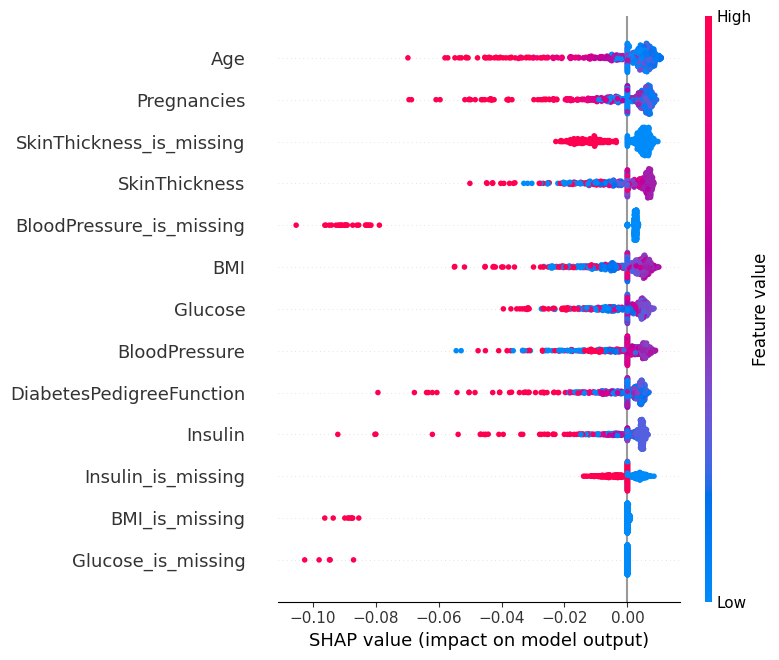

In [7]:

print("\nInitializing SHAP Explainer")
# Now we will use shap.kmeans to create a small, weighted summary of the baseline data
# This summary acts as the background distribution and makes the explainer run much faster
background_summary = shap.kmeans(X_base_scaled, 100)

# Create the explainer object
# We are creating a KernelExplainer, passing it our model's scoring function and the background data
explainer = shap.KernelExplainer(iso_forest.score_samples, background_summary)
print("SHAP explainer created successfully.")

# Calculating the SHAP values for the baseline data
print("\nCalculating SHAP values for BASELINE data...")
# Note: This calculation may take a few minutes as X_base_scaled has 537 samples
shap_values_base = explainer.shap_values(X_base_scaled)

# Now, we will plot the SHAP summary for our baseline
print("Plotting SHAP summary for BASELINE data...")
print("--- SHAP BASELINE PLOT ---")
# This plot will show us what the model considers anomalous *before* any drift
shap.summary_plot(shap_values_base, X_base_scaled, plot_type="dot")

In [8]:
# Calculate Baseline Min/Max Stats for Correct Drift Simulation

print("Calculating baseline statistics for drift function.")

# Features that will be subject to drift (Glucose, BMI, Age)
features_to_drift = ['Glucose', 'BMI', 'Age']
X_base_stats = {}

for feature in features_to_drift:
    if feature in X_base_raw.columns:
        # Calculate stats only on non-NaN values in the BASELINE set
        f_min = np.nanmin(X_base_raw[feature])
        f_max = np.nanmax(X_base_raw[feature])
        f_range = f_max - f_min
        
        X_base_stats[feature] = {
            'f_min': f_min,
            'f_range': f_range
        }
        print(f" - {feature}: f_min={f_min:.3f}, f_max={f_max:.3f}")

print("Baseline statistics stored in X_base_stats.")

Calculating baseline statistics for drift function.
 - Glucose: f_min=44.000, f_max=197.000
 - BMI: f_min=18.200, f_max=67.100
 - Age: f_min=21.000, f_max=81.000
Baseline statistics stored in X_base_stats.


### Score Baseline and Test Sets

**Purpose**: Generate anomaly scores for both baseline and test sets using the trained Isolation Forest. Lower scores indicate more anomalous behavior.

**Scoring Process**:
- **Baseline anomaly scores**: Measure the baseline's own outliers (should have low rate due to clean training data)
- **Test anomaly scores**: Detect how many test samples deviate from the learned baseline normality
- **Predictions**: Convert scores to binary labels (-1 = anomaly, 1 = normal)

**Interpretation**:
- Higher test anomaly rate = More drift detected
- Comparison of baseline vs test rates reveals drift signal strength


In [9]:
# Experiment 1: Univariate Min/Max Drift (Glucose Only)
#Defining the feature for our univariate test
drift_features_uni = ['Glucose']
print (f"--- Running Univariate Experiment: Drifting {drift_features_uni} --")

# This prevents the FutureWarning by ensuring the columns can accept float values
X_test_raw_float_uni = X_test_raw.copy()
for col in continuous_cols:
    X_test_raw_float_uni[col] = X_test_raw_float_uni[col].astype(float) 

#1. Now we will apply min/max drift to the RAW (float-cast) test data
X_test_drifted_raw_uni = apply_minmax_drift(
    X_test_raw_float_uni, # Data to be drifted (test set)
    X_base_stats, # Baseline statistics (CRITICAL FIX)
    features=drift_features_uni,
    shift_f=shift_factor,
    range_f=range_factor,
    verbose=True
)
# Apply the "Impute THEN Scale" pipeline to the newly drifted data
print("\nApplying baseline-fitted 'Impute -> Scale' pipeline...")
#First, impute the drifted raw data
X_test_drifted_imputed_cont_uni = imputer.transform(X_test_drifted_raw_uni[continuous_cols])

#Second, scale the imputed data using the baseline scaler
X_test_drifted_scaled_cont_uni = scaler.transform(X_test_drifted_imputed_cont_uni)

#Finally, recombine with the binary indicator columns
X_test_scaled_uni = pd.concat([
    X_test_drifted_scaled_cont_uni,
    X_test_drifted_raw_uni[indicator_cols]
], axis=1)
print("Univariate pipeline complete.")

#Scoring the new drifted data
print("\n--- Univariate Scoring Results ---")
#Get the raw anomaly scores from the model
test_scores_uni = iso_forest.score_samples (X_test_scaled_uni)
#Get the binary predictions (-1 for anomaly, 1 for normal)
test_predictions_uni = iso_forest.predict(X_test_scaled_uni)
# Count how many samples are flagged as anomalous
test_anomaly_count_uni = (test_predictions_uni == -1).sum()

#Calculate the percentage of anomalies
test_anomaly_rate_uni = test_anomaly_count_uni / len(test_predictions_uni)

# Recalculate the baseline anomaly rate for a clear comparison
baseline_predictions = iso_forest.predict(X_base_scaled)
baseline_anomaly_rate = (baseline_predictions == -1).sum()/ len(baseline_predictions)
print (f" Baseline Anomaly Rate: {baseline_anomaly_rate:.2%}")
print (f" Univariate Test Anomaly Rate: {test_anomaly_rate_uni:.2%}")
# Computing the detection ratio
detection_ratio_uni = test_anomaly_rate_uni / baseline_anomaly_rate if baseline_anomaly_rate > 0 else 0
print(f"\nDETECTION METRICS (UNIVARIATE): ")
print (f" • Detection Ratio: {detection_ratio_uni:.3f}x")

--- Running Univariate Experiment: Drifting ['Glucose'] --
MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)
Shift Factor: 0.4 | Range Factor: 1.5
Features: ['Glucose']

Glucose:
 Original (BASELINE): [44.000, 197.000]
 Drifted (TARGET): [17.600, 247.100]
 Test Set: mean=122.104, std=30.593
 Drifted Test: mean=134.756, std=45.889
 → Mean shift: +10.362% | Std change: +50.000%

Applying baseline-fitted 'Impute -> Scale' pipeline...
Univariate pipeline complete.

--- Univariate Scoring Results ---
 Baseline Anomaly Rate: 20.11%
 Univariate Test Anomaly Rate: 22.94%

DETECTION METRICS (UNIVARIATE): 
 • Detection Ratio: 1.141x


VALIDATING: Univariate Drift (on ['Glucose'])
--- Feature: Glucose ---
  Baseline Mean: 0.000
  Drifted Mean: 0.438
  P-value: 9.2328e-04
  Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: BMI ---
  Baseline Mean: -0.000
  Drifted Mean: 0.048
  P-value: 7.6733e-01
  Conclusion: Distributions are NOT different (No Drift).

--- Feature: Age ---
  Baseline Mean: 0.000
  Drifted Mean: 0.044
  P-value: 5.0650e-01
  Conclusion: Distributions are NOT different (No Drift).


Calculating SHAP values for UNIVARIATE drift...


  0%|          | 0/231 [00:00<?, ?it/s]

Plotting SHAP summary for UNIVARIATE drift...
--- SHAP UNIVARIATE PLOT ---


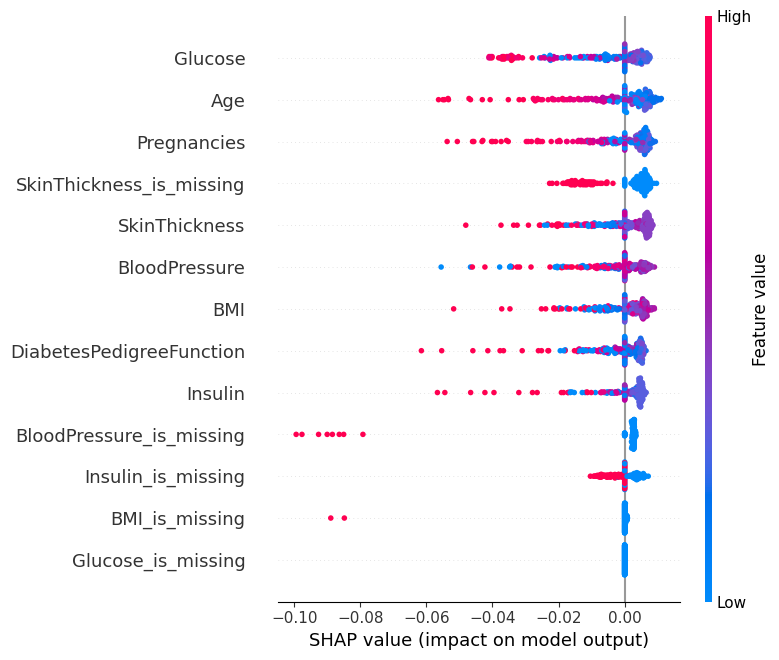

In [10]:
# Validation 1: K-S Test & SHAP (Univariate)

print("="*60)
print(f"VALIDATING: Univariate Drift (on {drift_features_uni})")
print("="*60)

# Running the K-S Test validation
# We will loop through the drifted feature and two control features
for feature in ['Glucose', 'BMI', 'Age']: # Test drifted feature + 2 controls
    # Get the original baseline data
    baseline_sample = X_base_scaled[feature]
    # Get the new drifted data
    drifted_sample = X_test_scaled_uni[feature]
    # Now we will compute the K-S test
    ks_stat, p_value = ks_2samp(baseline_sample, drifted_sample)
    
    print(f"--- Feature: {feature} ---")
    print(f"  Baseline Mean: {baseline_sample.mean():.3f}")
    print(f"  Drifted Mean: {drifted_sample.mean():.3f}")
    print(f"  P-value: {p_value:.4e}")
    # Check if the p-value is significant
    if p_value < 0.05:
        print("  Conclusion: Distributions are DIFFERENT (Drift Confirmed).\n")
    else:
        print("  Conclusion: Distributions are NOT different (No Drift).\n")

# Performing the SHAP Analysis for the univariate drift

print("\nCalculating SHAP values for UNIVARIATE drift...")
# Compute the SHAP values for the drifted test set
shap_values_uni = explainer.shap_values(X_test_scaled_uni)

print("Plotting SHAP summary for UNIVARIATE drift...")
print("--- SHAP UNIVARIATE PLOT ---")
# This plot shows us *why* the model flagged new anomalies
shap.summary_plot(shap_values_uni, X_test_scaled_uni, plot_type="dot")

In [11]:
# Experiment 2: Multivariate Min/Max Drift (Glucose, BMI, Age)
# Define the features for our multivariate test
drift_features_multi = ['Glucose', 'BMI', 'Age']
print (f"--- Running Multivariate Experiment: Drifting {drift_features_multi} ---")

# This prevents the FutureWarning by ensuring the columns can accept float values
X_test_raw_float_multi = X_test_raw.copy()
for col in continuous_cols:
    X_test_raw_float_multi[col] = X_test_raw_float_multi[col].astype(float) 

# Now we will apply min/max drift to the RAW (float-cast) test data
X_test_drifted_raw_multi = apply_minmax_drift(
    X_test_raw_float_multi, # Data to be drifted (test set)
    X_base_stats, # Baseline statistics (CRITICAL FIX)
    features=drift_features_multi,
    shift_f=shift_factor,
    range_f=range_factor,
    verbose=True
)

# Apply the "Impute THEN Scale" pipeline to this multivariate drifted data
print("\nApplying baseline-fitted 'Impute -> Scale' pipeline...")
# Imputing the drifted raw data first
X_test_drifted_imputed_cont_multi = imputer.transform(X_test_drifted_raw_multi[continuous_cols])
#Scaling the imputed data with the baseline scaler
X_test_drifted_scaled_cont_multi = scaler.transform(X_test_drifted_imputed_cont_multi)

# Now we recombine with the binary indicator columns
X_test_scaled_multi = pd.concat([
    X_test_drifted_scaled_cont_multi,
    X_test_drifted_raw_multi[indicator_cols]
], axis=1)
print("Multivariate pipeline complete.")

# Score the new multivariate drifted data
print("\n--- Multivariate Scoring Results ---")
#Get the raw anomaly scores
test_scores_multi = iso_forest.score_samples (X_test_scaled_multi)

#Get the binary predictions
test_predictions_multi = iso_forest.predict(X_test_scaled_multi)
# Count the new anomalies
test_anomaly_count_multi = (test_predictions_multi == -1).sum()
#Calculate the new anomaly rate
test_anomaly_rate_multi = test_anomaly_count_multi / len(test_predictions_multi)

# Print the comparison of anomaly rates
print (f" Baseline Anomaly Rate: {baseline_anomaly_rate:.2%}")
print (f" Multivariate Test Anomaly Rate: {test_anomaly_rate_multi:.2%}")

# Computing the final detection ratio
detection_ratio_multi = test_anomaly_rate_multi/ baseline_anomaly_rate if baseline_anomaly_rate > 0 else 0
print (f"\nDETECTION METRICS (MULTIVARIATE):")
print (f" • Detection Ratio: {detection_ratio_multi:.3f}x")

--- Running Multivariate Experiment: Drifting ['Glucose', 'BMI', 'Age'] ---
MIN/MAX AFFINE DRIFT TRANSFORMATION (NaN-Safe - BASELINE-FITTED)
Shift Factor: 0.4 | Range Factor: 1.5
Features: ['Glucose', 'BMI', 'Age']

Glucose:
 Original (BASELINE): [44.000, 197.000]
 Drifted (TARGET): [17.600, 247.100]
 Test Set: mean=122.104, std=30.593
 Drifted Test: mean=134.756, std=45.889
 → Mean shift: +10.362% | Std change: +50.000%

BMI:
 Original (BASELINE): [18.200, 67.100]
 Drifted (TARGET): [7.280, 80.630]
 Test Set: mean=32.692, std=6.456
 Drifted Test: mean=29.018, std=9.684
 → Mean shift: -11.239% | Std change: +50.000%

Age:
 Original (BASELINE): [21.000, 81.000]
 Drifted (TARGET): [8.400, 98.400]
 Test Set: mean=33.602, std=11.917
 Drifted Test: mean=27.303, std=17.875
 → Mean shift: -18.746% | Std change: +50.000%

Applying baseline-fitted 'Impute -> Scale' pipeline...
Multivariate pipeline complete.

--- Multivariate Scoring Results ---
 Baseline Anomaly Rate: 20.11%
 Multivariate Test

VALIDATING: Multivariate Drift (on ['Glucose', 'BMI', 'Age'])
--- Feature: Glucose ---
  Baseline Mean: 0.000
  Drifted Mean:  0.438
  P-value: 9.2328e-04
  Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: BMI ---
  Baseline Mean: -0.000
  Drifted Mean:  -0.469
  P-value: 1.1062e-08
  Conclusion: Distributions are DIFFERENT (Drift Confirmed).

--- Feature: Age ---
  Baseline Mean: 0.000
  Drifted Mean:  -0.495
  P-value: 4.7631e-39
  Conclusion: Distributions are DIFFERENT (Drift Confirmed).


Calculating SHAP values for MULTIV'ARIATE drift...


  0%|          | 0/231 [00:00<?, ?it/s]

Plotting SHAP summary for MULTIVARIATE drift...


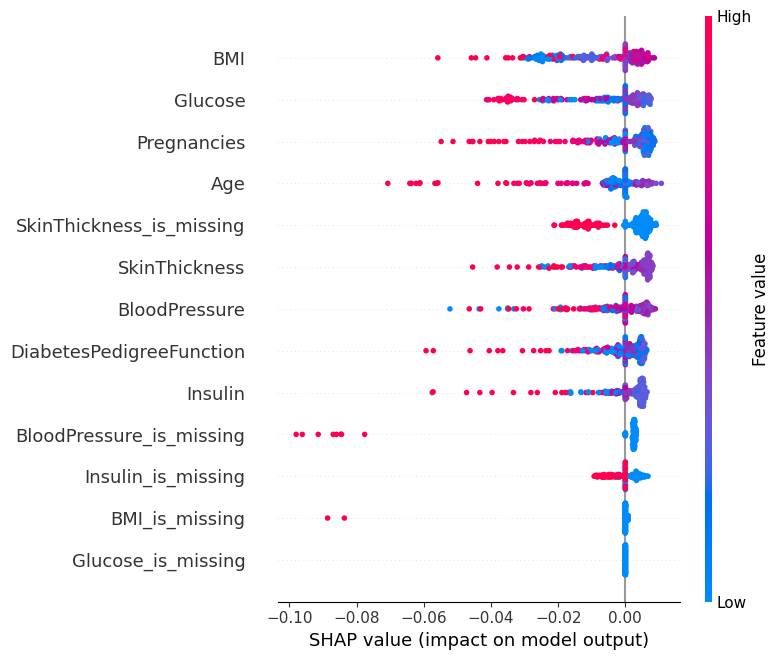

In [12]:
# Validation 2: K-S Test & SHAP (Multivariate)
print("="*60)
print(f"VALIDATING: Multivariate Drift (on {drift_features_multi})")
print("="*60)

# Now we will validate the multivariate drift using the K-S test
# Loop through each feature that we drifted
for feature in drift_features_multi:
    # Get the original baseline data
    baseline_sample = X_base_scaled[feature]
    # Get the new multivariate drifted data
    drifted_sample = X_test_scaled_multi[feature]
    # Compute the K-S test
    ks_stat, p_value = ks_2samp(baseline_sample, drifted_sample)
    
    print(f"--- Feature: {feature} ---")
    print(f"  Baseline Mean: {baseline_sample.mean():.3f}")
    print(f"  Drifted Mean:  {drifted_sample.mean():.3f}")
    print(f"  P-value: {p_value:.4e}")
    # Checking if the distributions are statistically different
    if p_value < 0.05:
        print("  Conclusion: Distributions are DIFFERENT (Drift Confirmed).\n")
    else:
        print("  Conclusion: Distributions are NOT different (No Drift).\n")

# Performing the SHAP Analysis for multivariate drift
print("\nCalculating SHAP values for MULTIV'ARIATE drift...")

shap_values_multi = explainer.shap_values(X_test_scaled_multi)

print("Plotting SHAP summary for MULTIVARIATE drift...")
# This plot will show all three features contributing to the anomaly scores
shap.summary_plot(shap_values_multi, X_test_scaled_multi, plot_type="dot")

### Conclusion: Isolation Forest Sensitivity to Abrupt Drift

This experiment successfully quantified the mechanistic response of the **Isolation Forest** algorithm to Abrupt Affine Drift. By establishing a fixed baseline sensitivity (`contamination=0.2`), we isolated the model's ability to detect sudden distributional shocks independent of threshold tuning.

#### Quantitative Results Summary

The table below summarizes the anomaly detection rates across the simulated drift scenarios.

| Drift Scenario | New Anomaly Rate | **Detection Ratio** | Validation (K-S Test) |
| :--- | :--- | :--- | :--- |
| **Baseline** (No Drift) | 20.11% | $1.00\text{x}$ | N/A |
| **Univariate** (Glucose) | 22.94% | **$1.14\text{x}$** | Confirmed ($p < 0.05$) |
| **Multivariate** (3 Feat.) | 28.75% | **$1.42\text{x}$** | Confirmed (All $p < 0.05$) |

#### Critical Analysis

**1. Sensitivity Limitation (The "Affine" Challenge)**
Unlike the *Gradual Multiplicative Drift* experiment (where Isolation Forest achieved a 4.4x ratio), the model showed **moderate sensitivity** ($1.42\text{x}$) to this *Abrupt Affine Shift*.
* **Interpretation:** This suggests that Isolation Forest's axis-parallel partitioning is less effective at detecting "Shift + Stretch" transformations (Affine) than it is at detecting "Pure Multiplicative" expansion. The drift did not push data points far enough into the "empty" isolation zones to trigger a massive spike in anomaly scores.

**2. Multivariate Amplification**
Despite the moderate overall sensitivity, the model demonstrated clear **feature synergy**. The detection signal grew from $1.14\text{x}$ (Univariate) to $1.42\text{x}$ (Multivariate), confirming that the ensemble correctly aggregates outlier scores across multiple drifting dimensions.

**3. Explainability & Validity**
The validity of the detection signal was confirmed via **SHAP**.
* **Baseline:** Driven by static features like `Age` and `Pregnancies`.
* **Post-Drift:** The SHAP summary plots successfully captured the shift, with `Glucose`, `BMI`, and `Age` rising to become the dominant contributors to the anomaly scores. This confirms the model was reacting to the injected signal, not noise.

#### Final Verdict

The Isolation Forest provides a **stable but conservative** baseline for detecting Abrupt Affine Drift. While it successfully flags the systemic shift, its detection ratio ($1.42\text{x}$) indicates that for this specific type of "shock," a density-based or kernel-based method (like OCSVM) may be required to achieve higher sensitivity.